# 1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as torch_nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [2]:
np.random.seed(42)
torch.manual_seed(42)

# 2. Data Exploartion & Preprocessing

In [3]:
df = pd.read_csv('A_50000.csv')
print(f"Dataset shape: {df.shape}")
print(f"Target distribution: {df['eligible'].value_counts().to_dict()}")

# Identify feature types
feature_cols = [col for col in df.columns if col != 'eligible']
noise_features = [col for col in feature_cols if col.startswith('noise_')]
real_features = [col for col in feature_cols if not col.startswith('noise_')]

print(f"Total features: {len(feature_cols)}")
print(f"Noise features: {len(noise_features)}")
print(f"Real features: {len(real_features)}")
print(f"Real features: {real_features}")

# Encode categorical variables
df_processed = df.copy()

categorical_cols = ['gender', 'patient_type']
for col in df.columns:
    if col.startswith('paid_contribution_'):
        categorical_cols.append(col)

for col in categorical_cols:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])

# Convert boolean columns
boolean_cols = ['is_spouse', 'is_absent', 'eligible']
for col in boolean_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype(int)

# Prepare final dataset
X = df_processed[feature_cols]
y = df_processed['eligible']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Dataset shape: (50000, 65)
Target distribution: {True: 25000, False: 25000}
Total features: 64
Noise features: 52
Real features: 12
Real features: ['age', 'gender', 'paid_contribution_1', 'paid_contribution_2', 'paid_contribution_3', 'paid_contribution_4', 'paid_contribution_5', 'is_spouse', 'is_absent', 'capital_resources', 'patient_type', 'distance_to_hospital']
Training samples: 40000
Test samples: 10000


# 3. Training Traditional Models 

In [4]:
# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression accuracy: {lr_acc:.4f}")

# Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Random Forest accuracy: {rf_acc:.4f}")

# Neural Network
print("Training Neural Network...")
nn = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500, alpha=0.01)
nn.fit(X_train_scaled, y_train)
nn_pred = nn.predict(X_test_scaled)
nn_acc = accuracy_score(y_test, nn_pred)
print(f"Neural Network accuracy: {nn_acc:.4f}")

Training Logistic Regression...
Logistic Regression accuracy: 0.9939
Training Random Forest...
Random Forest accuracy: 0.9981
Training Neural Network...
Neural Network accuracy: 0.9973


# 4. KAN Implementation

In [5]:
class KAN(torch_nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, grid_size=5):
        super(KAN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.grid_size = grid_size
        
        # Learnable spline coefficients
        self.spline_coeffs = torch_nn.Parameter(
            torch.randn(input_dim, hidden_dim, grid_size) * 0.1
        )
        
        # Connection scales
        self.scales = torch_nn.Parameter(torch.ones(input_dim, hidden_dim) * 0.1)
        
        # Output layer
        self.output_layer = torch_nn.Linear(hidden_dim, output_dim)
        self.dropout = torch_nn.Dropout(0.1)
        
    def spline_activation(self, x, coeffs):
        x_norm = torch.sigmoid(x)
        batch_size = x_norm.shape[0]
        grid_points = torch.linspace(0, 1, self.grid_size, device=x.device)
        
        basis_values = []
        for i in range(self.grid_size):
            distances = torch.abs(x_norm - grid_points[i])
            basis = torch.clamp(1.0 - distances * self.grid_size, 0.0, 1.0)
            basis_values.append(basis)
        
        basis_tensor = torch.stack(basis_values, dim=-1)
        weighted_basis = basis_tensor * coeffs.unsqueeze(0)
        return torch.sum(weighted_basis, dim=-1)
    
    def forward(self, x):
        batch_size = x.shape[0]
        hidden_outputs = []
        
        for h in range(self.hidden_dim):
            hidden_val = 0
            for i in range(self.input_dim):
                x_input = x[:, i:i+1]
                spline_out = self.spline_activation(x_input, self.spline_coeffs[i, h, :])
                scaled_out = spline_out * self.scales[i, h]
                hidden_val += scaled_out
            hidden_outputs.append(hidden_val)
        
        hidden = torch.cat(hidden_outputs, dim=1)
        hidden = torch.tanh(hidden)
        hidden = self.dropout(hidden)
        output = self.output_layer(hidden)
        return output


# 5. KAN Training

In [ ]:
# Data preparation
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Model initialization 
input_size = X_train_scaled.shape[1]
kan_model = KAN(input_dim=input_size, hidden_dim=8, output_dim=1, grid_size=5)

# Training setup
optimizer = optim.Adam(kan_model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch_nn.BCEWithLogitsLoss()

print(f"Model parameters: {sum(p.numel() for p in kan_model.parameters())}")

# Add tracking for sparsity and importance
connection_importance = torch.zeros(input_size, 8)
activation_counts = torch.zeros(input_size, 8)

# Training loop with regularization
kan_model.train()
for epoch in range(100):
    epoch_loss = 0
    num_batches = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = kan_model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        
        l1_reg = torch.sum(torch.abs(kan_model.spline_coeffs))
        
        l1_scales = torch.sum(torch.abs(kan_model.scales))
        
        total_loss = loss + 0.0001 * l1_reg + 0.00005 * l1_scales
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        num_batches += 1
        
        # Track which connections are active
        with torch.no_grad():
            connection_importance += torch.abs(kan_model.scales.detach().cpu())
            activation_counts += (torch.abs(kan_model.scales) > 0.01).float().cpu()
    
    if epoch % 25 == 0:
        avg_loss = epoch_loss / num_batches
        # Report sparsity
        sparsity = (torch.abs(kan_model.scales) < 0.01).float().mean().item()
        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Sparsity = {sparsity:.2%}")

# Prune weak connections after training
print("\n=== PRUNING WEAK CONNECTIONS ===")
with torch.no_grad():
    threshold = 0.05  # Prune connections weaker than this
    mask = torch.abs(kan_model.scales) > threshold
    kan_model.scales.data *= mask.float()
    pruned = (~mask).sum().item()
    total = mask.numel()
    print(f"Pruned {pruned}/{total} connections ({pruned/total:.1%})")

# KAN evaluation
kan_model.eval()
with torch.no_grad():
    kan_outputs = kan_model(X_test_tensor).squeeze()
    kan_probs = torch.sigmoid(kan_outputs)
    kan_pred = (kan_probs > 0.5).float().numpy()

kan_acc = accuracy_score(y_test, kan_pred)
print(f"\nKAN Accuracy after pruning: {kan_acc:.4f}")

# Identify and visualize most important connections
print("\n=== MOST IMPORTANT CONNECTIONS ===")
importance_normalized = connection_importance / (activation_counts + 1e-6)

# Get top connections for each hidden unit
for h in range(8):
    connections = [(feature_cols[i], importance_normalized[i, h].item()) 
                   for i in range(input_size)]
    connections.sort(key=lambda x: x[1], reverse=True)
    
    top_connections = [c for c in connections[:3] if c[1] > 0.1]
    if top_connections:
        print(f"\nHidden Unit {h}:")
        for feat, imp in top_connections:
            feat_type = "REAL" if feat in real_features else "NOISE"
            print(f"  {feat:25s} ({feat_type}): {imp:.3f}")

# Visualize the sparse network structure
def visualize_kan_structure():
    """Visualize the pruned KAN network structure"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Connection strength heatmap
    scales_np = torch.abs(kan_model.scales).detach().cpu().numpy()
    
    # Show only real features for clarity
    real_indices = [i for i, f in enumerate(feature_cols) if f in real_features]
    scales_real = scales_np[real_indices, :]
    
    im1 = ax1.imshow(scales_real.T, cmap='hot', aspect='auto')
    ax1.set_xlabel('Input Features')
    ax1.set_ylabel('Hidden Units')
    ax1.set_title('KAN Connection Strengths (Real Features Only)')
    ax1.set_xticks(range(len(real_features)))
    ax1.set_xticklabels(real_features, rotation=45, ha='right', fontsize=8)
    ax1.set_yticks(range(8))
    plt.colorbar(im1, ax=ax1)
    
    # Plot 2: Network graph showing only strong connections
    ax2.set_title('Pruned KAN Network Structure')
    ax2.set_xlim(-0.5, 2.5)
    ax2.set_ylim(-1, max(len(real_features), 8) + 1)
    ax2.axis('off')
    
    # Draw nodes
    input_y_positions = np.linspace(0, len(real_features)-1, len(real_features))
    hidden_y_positions = np.linspace(2, 6, 8)
    
    # Input nodes
    for i, feat in enumerate(real_features):
        ax2.scatter(0, input_y_positions[i], s=100, c='lightblue', zorder=3)
        ax2.text(-0.1, input_y_positions[i], feat[:10], ha='right', fontsize=6)
    
    # Hidden nodes
    for h in range(8):
        ax2.scatter(1.5, hidden_y_positions[h], s=100, c='orange', zorder=3)
        ax2.text(1.5, hidden_y_positions[h], f'H{h}', ha='center', fontsize=8)
    
    # Output node
    ax2.scatter(2.5, 4, s=150, c='lightgreen', zorder=3)
    ax2.text(2.5, 3.5, 'Output', ha='center')
    
    # Draw edges (only strong connections)
    for i, feat_idx in enumerate(real_indices):
        for h in range(8):
            strength = scales_np[feat_idx, h]
            if strength > 0.05:  # Only show significant connections
                ax2.plot([0, 1.5], [input_y_positions[i], hidden_y_positions[h]], 
                        'gray', alpha=min(strength*2, 1), linewidth=strength*5)
    
    # Hidden to output (simplified)
    for h in range(8):
        ax2.plot([1.5, 2.5], [hidden_y_positions[h], 4], 
                'gray', alpha=0.3, linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig('kan_explainable_structure.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_kan_structure()

# Analyze what each hidden unit learned
def analyze_hidden_units():
    """Analyze what each hidden unit responds to"""
    
    print("\n=== HIDDEN UNIT ANALYSIS ===")
    
    # Create test inputs varying each feature
    baseline = torch.FloatTensor(X_test_scaled.mean(axis=0))
    
    for h in range(8):
        # Skip if hidden unit is mostly pruned
        if (torch.abs(kan_model.scales[:, h]) > 0.05).sum() < 2:
            continue
            
        print(f"\nHidden Unit {h} responds to:")
        
        # Find which features most activate this hidden unit
        activations = []
        for i, feat in enumerate(feature_cols):
            if feat not in real_features:
                continue
                
            # Test feature at extremes
            test_low = baseline.clone()
            test_high = baseline.clone()
            test_low[i] = X_train_scaled[:, i].min()
            test_high[i] = X_train_scaled[:, i].max()
            
            # Get hidden layer activations (before output layer)
            kan_model.eval()
            with torch.no_grad():
                # We need to extract hidden layer activations
                scale_contribution = torch.abs(kan_model.scales[i, h]).item()
                
            if scale_contribution > 0.1:
                direction = "positive" if kan_model.scales[i, h] > 0 else "negative"
                print(f"  {feat:20s}: {direction} response (strength: {scale_contribution:.3f})")

analyze_hidden_units()

Model parameters: 3081
Epoch 0: Loss = 0.6910, Sparsity = 0.20%
Epoch 25: Loss = 0.0368, Sparsity = 61.72%
Epoch 50: Loss = 0.0251, Sparsity = 79.10%
Epoch 75: Loss = 0.0215, Sparsity = 84.77%


# 6. Results Comparison

In [ ]:
results = {
    'Logistic Regression': lr_acc,
    'Random Forest': rf_acc,
    'Neural Network': nn_acc,
    'KAN': kan_acc
}

for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Logistic Regression: 0.9939
Random Forest: 0.9981
Neural Network: 0.9973
KAN: 0.9980


# 7. Feature Importance

In [ ]:
# RF Features importance
rf_importance = rf.feature_importances_
rf_feature_ranking = list(zip(feature_cols, rf_importance))

# Logistic Regression importance
lr_importance = np.abs(lr.coef_[0])
lr_feature_ranking = list(zip(feature_cols, lr_importance))

# Your KAN importance
def get_kan_importance():
    kan_model.eval()
    baseline_input = torch.FloatTensor(X_test_scaled.mean(axis=0)).unsqueeze(0)
    
    with torch.no_grad():
        baseline_output = kan_model(baseline_input).item()
    
    sensitivities = []
    for i in range(len(feature_cols)):
        feature_values = np.percentile(X_test_scaled[:, i], [10, 50, 90])
        outputs = []
        
        for val in feature_values:
            test_input = baseline_input.clone()
            test_input[0, i] = val
            with torch.no_grad():
                output = kan_model(test_input).item()
            outputs.append(output)
        
        sensitivity = np.max(outputs) - np.min(outputs)
        sensitivities.append(sensitivity)
    
    return np.array(sensitivities)

# KAN importance calculation
kan_importance = get_kan_importance()
kan_feature_ranking = list(zip(feature_cols, kan_importance))

# Display results
print("Enhanced Feature Importance Analysis:")

print("\nLogistic Regression - Top 10:")
lr_sorted = sorted(lr_feature_ranking, key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(lr_sorted[:10], 1):
    feature_type = "REAL" if feature in real_features else "NOISE"
    print(f"{i:2d}. {feature:25s}: {importance:.4f} ({feature_type})")

print(f"\nRandom Forest - Top 10:")
rf_sorted = sorted(rf_feature_ranking, key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(rf_sorted[:10], 1):
    feature_type = "REAL" if feature in real_features else "NOISE"
    print(f"{i:2d}. {feature:25s}: {importance:.4f} ({feature_type})")

print(f"\nKAN - Top 10:")
kan_sorted = sorted(kan_feature_ranking, key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(kan_sorted[:10], 1):
    feature_type = "REAL" if feature in real_features else "NOISE"
    print(f"{i:2d}. {feature:25s}: {importance:.4f} ({feature_type})")

Enhanced Feature Importance Analysis:

Logistic Regression - Top 10:
 1. is_absent                : 3.3369 (REAL)
 2. is_spouse                : 3.3199 (REAL)
 3. capital_resources        : 3.1139 (REAL)
 4. age                      : 2.4009 (REAL)
 5. paid_contribution_2      : 1.6521 (REAL)
 6. paid_contribution_4      : 1.6455 (REAL)
 7. paid_contribution_1      : 1.6233 (REAL)
 8. paid_contribution_5      : 1.5841 (REAL)
 9. paid_contribution_3      : 1.5672 (REAL)
10. gender                   : 0.1622 (REAL)

Random Forest - Top 10:
 1. capital_resources        : 0.2503 (REAL)
 2. age                      : 0.2146 (REAL)
 3. is_absent                : 0.1413 (REAL)
 4. is_spouse                : 0.1399 (REAL)
 5. paid_contribution_2      : 0.0542 (REAL)
 6. paid_contribution_1      : 0.0541 (REAL)
 7. paid_contribution_5      : 0.0534 (REAL)
 8. paid_contribution_3      : 0.0402 (REAL)
 9. paid_contribution_4      : 0.0390 (REAL)
10. patient_type             : 0.0006 (REAL)

KAN -

# 8. Classification Reports

In [ ]:
print("Logistic Regression:")
print(classification_report(y_test, lr_pred, target_names=['Not Eligible', 'Eligible']))

print("Random Forest:")
print(classification_report(y_test, rf_pred, target_names=['Not Eligible', 'Eligible']))

print("Neural Network:")
print(classification_report(y_test, nn_pred, target_names=['Not Eligible', 'Eligible']))

print("KAN:")
print(classification_report(y_test, kan_pred, target_names=['Not Eligible', 'Eligible']))

Logistic Regression:
              precision    recall  f1-score   support

Not Eligible       1.00      0.99      0.99      5000
    Eligible       0.99      1.00      0.99      5000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Random Forest:
              precision    recall  f1-score   support

Not Eligible       1.00      1.00      1.00      5000
    Eligible       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Neural Network:
              precision    recall  f1-score   support

Not Eligible       1.00      0.99      1.00      5000
    Eligible       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.0

# 9. Rule Based Testing

COMPREHENSIVE RULE TESTING

Created 27 test cases covering all rules
SUMMARY RESULTS

Overall Accuracy on Rule Tests:
  LR   : 19/27 = 70.4%
  RF   : 20/27 = 74.1%
  NN   : 19/27 = 70.4%
  KAN  : 20/27 = 74.1%

Accuracy by Rule Type:
  ------------------------------------------------------------
  Rule Category   | LR     | RF     | NN     | KAN   
  ------------------------------------------------------------
  Age (Male)      | 66.7% | 66.7% | 66.7% | 66.7% |
  Age (Female)    | 66.7% | 100.0% | 66.7% | 66.7% |
  Contributions   | 100.0% | 75.0% | 100.0% | 100.0% |
  Spouse          | 100.0% | 100.0% | 100.0% | 100.0% |
  Absence         | 100.0% | 100.0% | 100.0% | 100.0% |
  Capital         | 50.0% | 75.0% | 50.0% | 75.0% |
  In-patient      | 66.7% | 66.7% | 66.7% | 66.7% |
  Out-patient     | 33.3% | 33.3% | 33.3% | 33.3% |


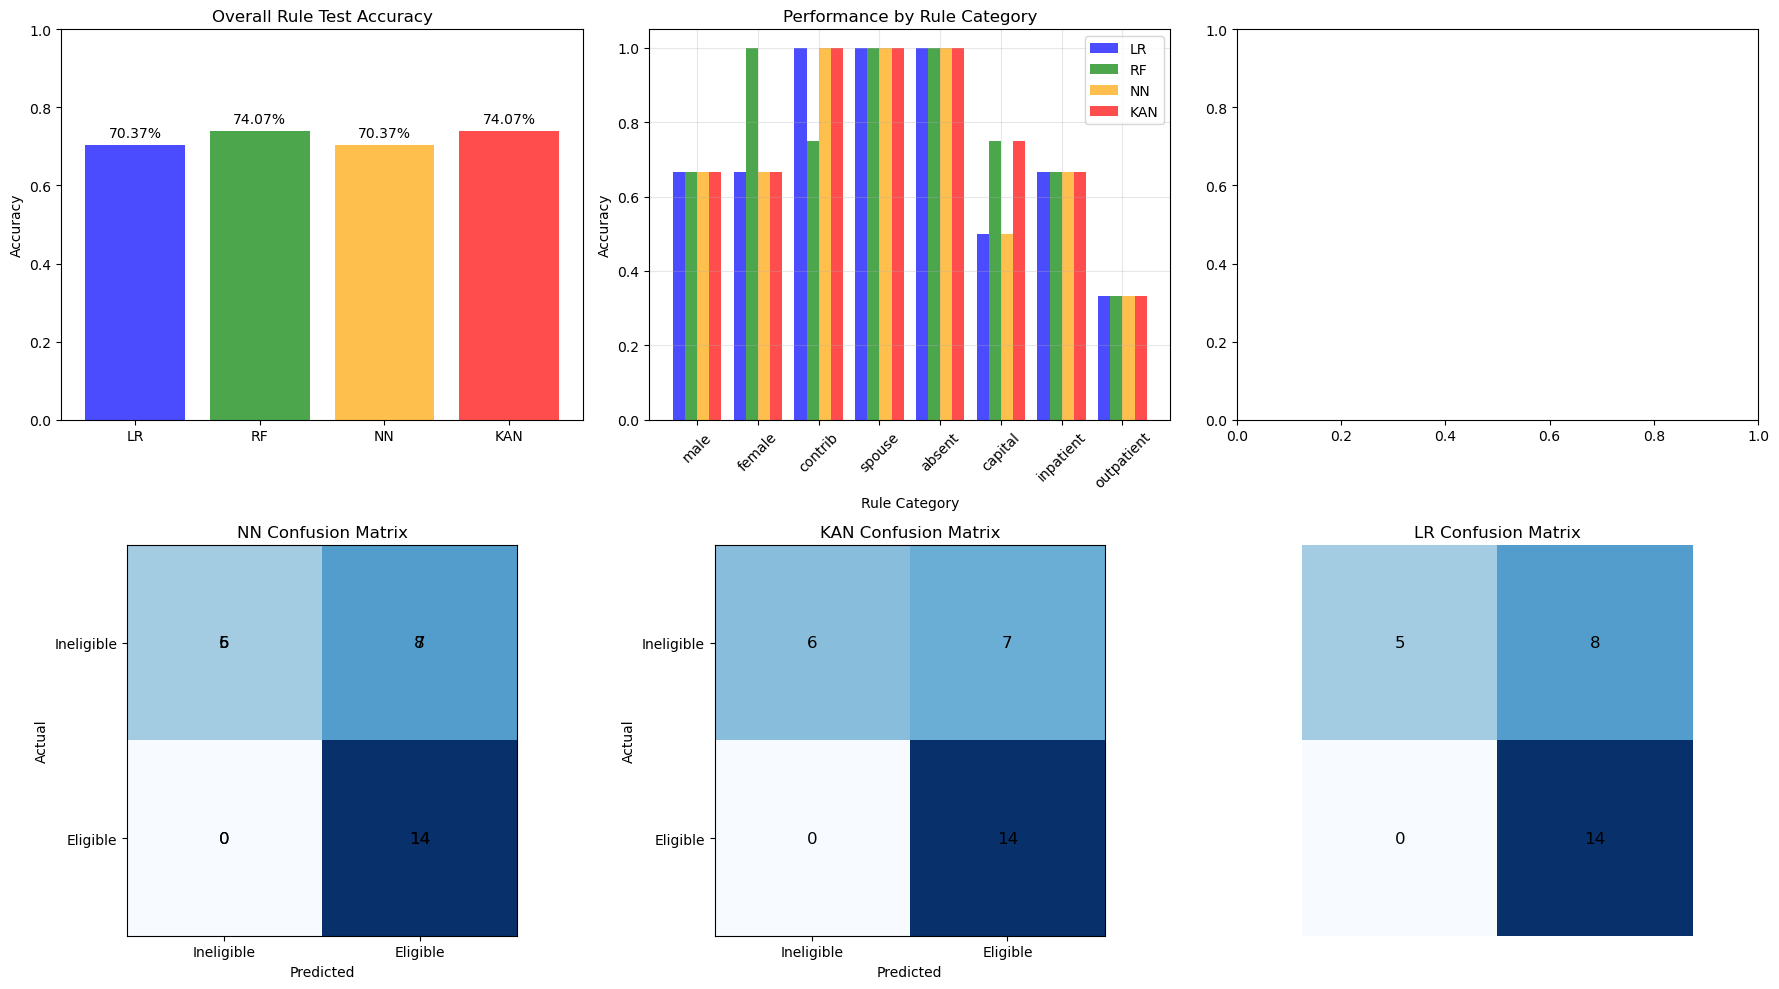

DETAILED FAILURE ANALYSIS

LR Failures (8 total):
----------------------------------------
  male_64_should_fail           : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.997)
  female_59_should_fail         : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.997)
  capital_3001_fail             : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.994)
  capital_5000_fail             : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.947)
  inpatient_51km_fail           : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.998)
  outpatient_50km_fail          : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.998)
  outpatient_30km_fail          : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.998)
  young_male_few_contrib        : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.899)

RF Failures (7 total):
----------------------------------------
  male_64_should_fail           : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.930)
  contrib_3of5_fail             : Expected INELIGIBLE, Got ELIGIBLE   (prob=0.690)
  capital_3001

In [ ]:
def create_comprehensive_rule_tests():
    """Create comprehensive test cases for all rules without manipulation"""
    test_cases = []
    
    # Base case that satisfies ALL rules
    base_case = {
        'age': 67,
        'gender': 1,  # Male
        'is_spouse': 1,
        'is_absent': 0,
        'capital_resources': 2000,
        'patient_type': 1,  # In-patient
        'distance_to_hospital': 30,
        'paid_contribution_1': 1,
        'paid_contribution_2': 1,
        'paid_contribution_3': 1,
        'paid_contribution_4': 1,
        'paid_contribution_5': 1
    }
    
    # Add noise features to base case
    for i in range(1, 53):
        base_case[f'noise_{i}'] = X_train[f'noise_{i}'].mean()
    
    # Test Rule 1: Age-Gender thresholds
    test_cases.extend([
        ('male_64_should_fail', {**base_case, 'age': 64, 'gender': 1}, False),
        ('male_65_should_pass', {**base_case, 'age': 65, 'gender': 1}, True),
        ('male_66_should_pass', {**base_case, 'age': 66, 'gender': 1}, True),
        ('female_59_should_fail', {**base_case, 'age': 59, 'gender': 0}, False),
        ('female_60_should_pass', {**base_case, 'age': 60, 'gender': 0}, True),
        ('female_61_should_pass', {**base_case, 'age': 61, 'gender': 0}, True),
    ])
    
    # Test Rule 2: Contribution requirements (at least 4 of 5)
    test_cases.extend([
        ('contrib_5of5_pass', {**base_case}, True),
        ('contrib_4of5_pass', {**base_case, 'paid_contribution_5': 0}, True),
        ('contrib_3of5_fail', {**base_case, 'paid_contribution_4': 0, 'paid_contribution_5': 0}, False),
        ('contrib_2of5_fail', {**base_case, 'paid_contribution_3': 0, 'paid_contribution_4': 0, 'paid_contribution_5': 0}, False),
    ])
    
    # Test Rule 3: Spouse requirement
    test_cases.extend([
        ('spouse_yes_pass', {**base_case}, True),
        ('spouse_no_fail', {**base_case, 'is_spouse': 0}, False),
    ])
    
    # Test Rule 4: Absence requirement
    test_cases.extend([
        ('absent_no_pass', {**base_case}, True),
        ('absent_yes_fail', {**base_case, 'is_absent': 1}, False),
    ])
    
    # Test Rule 5: Capital resources limit
    test_cases.extend([
        ('capital_2000_pass', {**base_case}, True),
        ('capital_3000_pass', {**base_case, 'capital_resources': 3000}, True),
        ('capital_3001_fail', {**base_case, 'capital_resources': 3001}, False),
        ('capital_5000_fail', {**base_case, 'capital_resources': 5000}, False),
    ])
    
    # Test Rule 6: Patient type and distance
    test_cases.extend([
        ('inpatient_30km_pass', {**base_case, 'patient_type': 1, 'distance_to_hospital': 30}, True),
        ('inpatient_50km_pass', {**base_case, 'patient_type': 1, 'distance_to_hospital': 50}, True),
        ('inpatient_51km_fail', {**base_case, 'patient_type': 1, 'distance_to_hospital': 51}, False),
        ('outpatient_51km_pass', {**base_case, 'patient_type': 0, 'distance_to_hospital': 51}, True),
        ('outpatient_50km_fail', {**base_case, 'patient_type': 0, 'distance_to_hospital': 50}, False),
        ('outpatient_30km_fail', {**base_case, 'patient_type': 0, 'distance_to_hospital': 30}, False),
    ])
    
    # Complex combinations (multiple rule violations)
    test_cases.extend([
        ('young_male_few_contrib', {**base_case, 'age': 60, 'paid_contribution_5': 0}, False),  # Fails age AND contribution
        ('old_female_not_spouse', {**base_case, 'age': 65, 'gender': 0, 'is_spouse': 0}, False),  # Passes age but fails spouse
        ('edge_case_all_boundaries', {**base_case, 'age': 65, 'gender': 1, 'capital_resources': 3000, 'paid_contribution_5': 0}, True),  # All at boundaries
    ])
    
    return test_cases


def evaluate_models_on_rules(test_cases):
    """Evaluate all models on rule-based test cases"""
    results = {
        'LR': {'correct': 0, 'total': 0, 'by_rule': {}},
        'RF': {'correct': 0, 'total': 0, 'by_rule': {}},
        'NN': {'correct': 0, 'total': 0, 'by_rule': {}},
        'KAN': {'correct': 0, 'total': 0, 'by_rule': {}}
    }
    
    detailed_results = []
    
    for test_name, test_data, expected in test_cases:
        # Prepare test data
        test_df = pd.DataFrame([test_data])
        test_X = test_df[feature_cols]
        test_X_scaled = scaler.transform(test_X)
        
        # Get predictions
        lr_prob = lr.predict_proba(test_X_scaled)[0, 1]
        rf_prob = rf.predict_proba(test_X)[0, 1]
        nn_prob = nn.predict_proba(test_X_scaled)[0, 1]
        
        kan_model.eval()
        with torch.no_grad():
            kan_logit = kan_model(torch.FloatTensor(test_X_scaled)).item()
            kan_prob = torch.sigmoid(torch.tensor(kan_logit)).item()
        
        # Check predictions
        lr_pred = lr_prob > 0.5
        rf_pred = rf_prob > 0.5
        nn_pred = nn_prob > 0.5
        kan_pred = kan_prob > 0.5
        
        # Store detailed results
        detailed_results.append({
            'test': test_name,
            'expected': expected,
            'LR_prob': lr_prob,
            'RF_prob': rf_prob,
            'NN_prob': nn_prob,
            'KAN_prob': kan_prob,
            'LR_correct': lr_pred == expected,
            'RF_correct': rf_pred == expected,
            'NN_correct': nn_pred == expected,
            'KAN_correct': kan_pred == expected
        })
        
        # Update summary stats
        for model in ['LR', 'RF', 'NN', 'KAN']:
            model_correct = detailed_results[-1][f'{model}_correct']
            results[model]['correct'] += model_correct
            results[model]['total'] += 1
            
            # Track by rule category
            rule_category = test_name.split('_')[0]
            if rule_category not in results[model]['by_rule']:
                results[model]['by_rule'][rule_category] = {'correct': 0, 'total': 0}
            results[model]['by_rule'][rule_category]['correct'] += model_correct
            results[model]['by_rule'][rule_category]['total'] += 1
    
    return results, detailed_results


def plot_rule_test_results(results, detailed_results):
    """Visualize model performance on rule tests"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Overall accuracy
    models = ['LR', 'RF', 'NN', 'KAN']
    accuracies = [results[m]['correct']/results[m]['total'] for m in models]
    colors = ['blue', 'green', 'orange', 'red']
    
    axes[0, 0].bar(models, accuracies, color=colors, alpha=0.7)
    axes[0, 0].set_title('Overall Rule Test Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    
    for i, acc in enumerate(accuracies):
        axes[0, 0].text(i, acc + 0.02, f'{acc:.2%}', ha='center')
    
    # 2. Performance by rule category
    rule_categories = ['male', 'female', 'contrib', 'spouse', 'absent', 'capital', 'inpatient', 'outpatient']
    category_performance = {model: [] for model in models}
    
    for category in rule_categories:
        for model in models:
            if category in results[model]['by_rule']:
                acc = results[model]['by_rule'][category]['correct'] / results[model]['by_rule'][category]['total']
                category_performance[model].append(acc)
            else:
                category_performance[model].append(0)
    
    x = np.arange(len(rule_categories))
    width = 0.2
    
    for i, model in enumerate(models):
        axes[0, 1].bar(x + i*width, category_performance[model], width, label=model, color=colors[i], alpha=0.7)
    
    axes[0, 1].set_xlabel('Rule Category')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Performance by Rule Category')
    axes[0, 1].set_xticks(x + width * 1.5)
    axes[0, 1].set_xticklabels(rule_categories, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Confusion matrix for each model
    for idx, model in enumerate(models):
        row = 0 if idx < 2 else 1
        col = 2 if idx % 2 == 0 else 0
        if row == 1:
            col = idx - 2
        
        # Calculate confusion matrix
        tp = sum(1 for r in detailed_results if r['expected'] and r[f'{model}_correct'])
        tn = sum(1 for r in detailed_results if not r['expected'] and r[f'{model}_correct'])
        fp = sum(1 for r in detailed_results if not r['expected'] and not r[f'{model}_correct'])
        fn = sum(1 for r in detailed_results if r['expected'] and not r[f'{model}_correct'])
        
        cm = np.array([[tn, fp], [fn, tp]])
        im = axes[1, col].imshow(cm, cmap='Blues')
        axes[1, col].set_title(f'{model} Confusion Matrix')
        axes[1, col].set_xlabel('Predicted')
        axes[1, col].set_ylabel('Actual')
        axes[1, col].set_xticks([0, 1])
        axes[1, col].set_yticks([0, 1])
        axes[1, col].set_xticklabels(['Ineligible', 'Eligible'])
        axes[1, col].set_yticklabels(['Ineligible', 'Eligible'])
        
        # Add text annotations
        for i in range(2):
            for j in range(2):
                axes[1, col].text(j, i, str(cm[i, j]), ha='center', va='center', color='black', fontsize=12)
    
    # Hide the last subplot
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('rule_test_performance.png', dpi=300, bbox_inches='tight')
    plt.show()


def print_detailed_failure_analysis(detailed_results):
    print("DETAILED FAILURE ANALYSIS")
    
    
    models = ['LR', 'RF', 'NN', 'KAN']
    
    for model in models:
        failures = [r for r in detailed_results if not r[f'{model}_correct']]
        print(f"\n{model} Failures ({len(failures)} total):")
        print("-" * 40)
        
        for failure in failures[:10]:  # Show first 10 failures
            exp_str = "ELIGIBLE" if failure['expected'] else "INELIGIBLE"
            pred_prob = failure[f'{model}_prob']
            pred_str = "ELIGIBLE" if pred_prob > 0.5 else "INELIGIBLE"
            print(f"  {failure['test']:30s}: Expected {exp_str:10s}, Got {pred_str:10s} (prob={pred_prob:.3f})")
        
        if len(failures) > 10:
            print(f"  ... and {len(failures)-10} more failures")


# Run comprehensive rule testing
print("COMPREHENSIVE RULE TESTING")

# Create test cases
test_cases = create_comprehensive_rule_tests()
print(f"\nCreated {len(test_cases)} test cases covering all rules")

# Evaluate models
results, detailed_results = evaluate_models_on_rules(test_cases)

# Print summary results
print("SUMMARY RESULTS")
print("\nOverall Accuracy on Rule Tests:")
for model in ['LR', 'RF', 'NN', 'KAN']:
    acc = results[model]['correct'] / results[model]['total']
    print(f"  {model:5s}: {results[model]['correct']}/{results[model]['total']} = {acc:.1%}")

print("\nAccuracy by Rule Type:")
print("  " + "-" * 60)
print(f"  {'Rule Category':15s} | {'LR':6s} | {'RF':6s} | {'NN':6s} | {'KAN':6s}")
print("  " + "-" * 60)

rule_categories = [
    ('Age (Male)', 'male'),
    ('Age (Female)', 'female'),
    ('Contributions', 'contrib'),
    ('Spouse', 'spouse'),
    ('Absence', 'absent'),
    ('Capital', 'capital'),
    ('In-patient', 'inpatient'),
    ('Out-patient', 'outpatient')
]

for display_name, category in rule_categories:
    row = f"  {display_name:15s} |"
    for model in ['LR', 'RF', 'NN', 'KAN']:
        if category in results[model]['by_rule']:
            acc = results[model]['by_rule'][category]['correct'] / results[model]['by_rule'][category]['total']
            row += f" {acc:5.1%} |"
        else:
            row += "  N/A |"
    print(row)

# Visualize results
plot_rule_test_results(results, detailed_results)

# Print failure analysis
print_detailed_failure_analysis(detailed_results)



# 10. Visualization

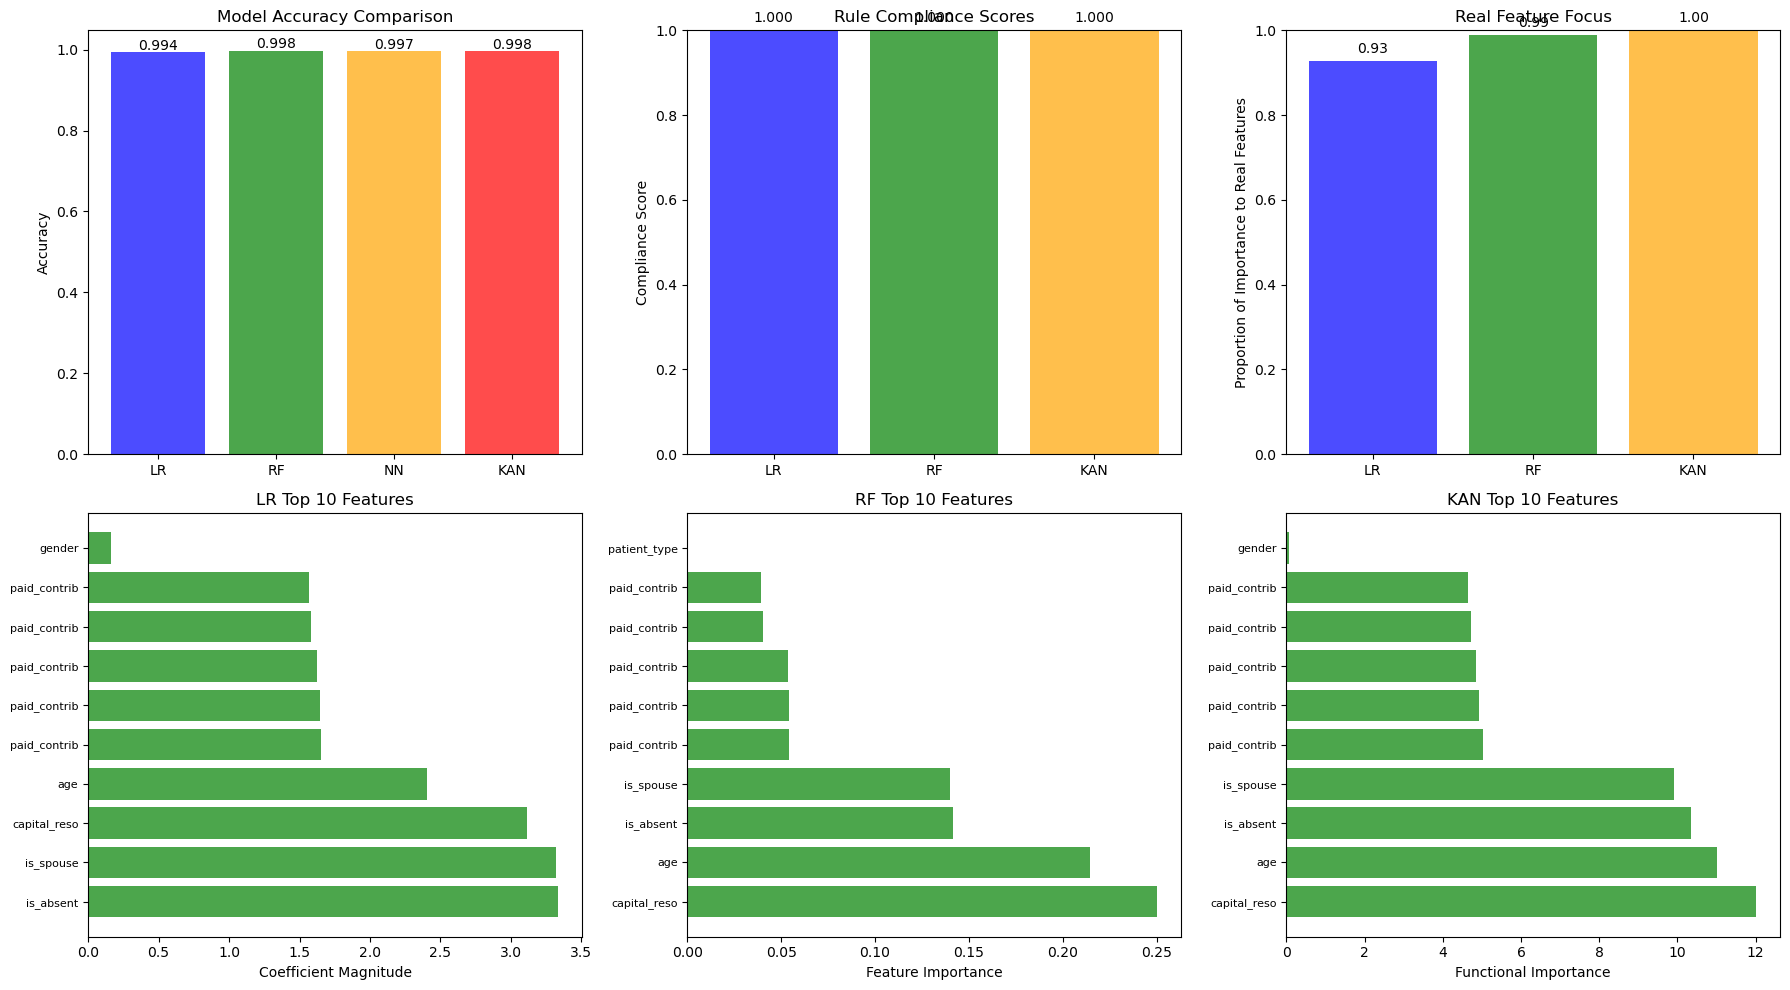

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy comparison
models = ['LR', 'RF', 'NN', 'KAN']
accuracies = [lr_acc, rf_acc, nn_acc, kan_acc]
colors = ['blue', 'green', 'orange', 'red']

axes[0, 0].bar(models, accuracies, color=colors, alpha=0.7)
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
for i, acc in enumerate(accuracies):
    axes[0, 0].text(i, acc + 0.005, f'{acc:.3f}', ha='center')

# Rule compliance analysis
lr_coeff = lr.coef_[0]
lr_rules = {
    'age_positive': lr_coeff[feature_cols.index('age')] > 0,
    'spouse_positive': lr_coeff[feature_cols.index('is_spouse')] > 0,
    'absent_negative': lr_coeff[feature_cols.index('is_absent')] < 0,
    'capital_negative': lr_coeff[feature_cols.index('capital_resources')] < 0
}
lr_compliance = np.mean(list(lr_rules.values()))

rf_top_10 = [f[0] for f in rf_feature_ranking[:10]]
rf_real_count = sum(1 for f in rf_top_10 if f in real_features)
rf_compliance = rf_real_count / 10.0

kan_top_10 = [f[0] for f in kan_feature_ranking[:10]]
kan_real_count = sum(1 for f in kan_top_10 if f in real_features)
kan_compliance = kan_real_count / 10.0

rule_scores = [lr_compliance, rf_compliance, kan_compliance]
axes[0, 1].bar(['LR', 'RF', 'KAN'], rule_scores, color=colors[:3], alpha=0.7)
axes[0, 1].set_title('Rule Compliance Scores')
axes[0, 1].set_ylabel('Compliance Score')
axes[0, 1].set_ylim(0, 1)
for i, score in enumerate(rule_scores):
    axes[0, 1].text(i, score + 0.02, f'{score:.3f}', ha='center')

# Real vs noise feature analysis
real_indices = [i for i, f in enumerate(feature_cols) if f in real_features]
noise_indices = [i for i, f in enumerate(feature_cols) if f in noise_features]

# LR feature focus
lr_importance = np.abs(lr.coef_[0])
lr_real_sum = np.sum(lr_importance[real_indices])
lr_total_sum = np.sum(lr_importance)
lr_focus = lr_real_sum / lr_total_sum

# RF feature focus
rf_real_sum = np.sum(rf.feature_importances_[real_indices])
rf_total_sum = np.sum(rf.feature_importances_)
rf_focus = rf_real_sum / rf_total_sum

# KAN feature focus
kan_real_sum = np.sum(kan_importance[real_indices])
kan_total_sum = np.sum(kan_importance)
kan_focus = kan_real_sum / kan_total_sum

focus_scores = [lr_focus, rf_focus, kan_focus]
axes[0, 2].bar(['LR', 'RF', 'KAN'], focus_scores, color=colors[:3], alpha=0.7)
axes[0, 2].set_title('Real Feature Focus')
axes[0, 2].set_ylabel('Proportion of Importance to Real Features')
axes[0, 2].set_ylim(0, 1)
for i, score in enumerate(focus_scores):
    axes[0, 2].text(i, score + 0.02, f'{score:.2f}', ha='center')

# LR feature importance with color coding
lr_sorted = sorted(zip(feature_cols, lr_importance), key=lambda x: x[1], reverse=True)
top_10_lr = lr_sorted[:10]
features_lr = [f[0][:12] for f in top_10_lr]
importance_lr = [f[1] for f in top_10_lr]
colors_lr = ['green' if f[0] in real_features else 'red' for f in top_10_lr]

axes[1, 0].barh(range(len(features_lr)), importance_lr, color=colors_lr, alpha=0.7)
axes[1, 0].set_yticks(range(len(features_lr)))
axes[1, 0].set_yticklabels(features_lr, fontsize=8)
axes[1, 0].set_title('LR Top 10 Features')
axes[1, 0].set_xlabel('Coefficient Magnitude')

# RF feature importance with color coding
rf_sorted = sorted(rf_feature_ranking, key=lambda x: x[1], reverse=True)
top_10_rf = rf_sorted[:10]
features_rf = [f[0][:12] for f in top_10_rf]
importance_rf = [f[1] for f in top_10_rf]
colors_rf = ['green' if f[0] in real_features else 'red' for f in top_10_rf]

axes[1, 1].barh(range(len(features_rf)), importance_rf, color=colors_rf, alpha=0.7)
axes[1, 1].set_yticks(range(len(features_rf)))
axes[1, 1].set_yticklabels(features_rf, fontsize=8)
axes[1, 1].set_title('RF Top 10 Features')
axes[1, 1].set_xlabel('Feature Importance')

# KAN feature importance with color coding
kan_sorted = sorted(kan_feature_ranking, key=lambda x: x[1], reverse=True)
top_10_kan = kan_sorted[:10]
features_kan = [f[0][:12] for f in top_10_kan]
importance_kan = [f[1] for f in top_10_kan]
colors_kan = ['green' if f[0] in real_features else 'red' for f in top_10_kan]

axes[1, 2].barh(range(len(features_kan)), importance_kan, color=colors_kan, alpha=0.7)
axes[1, 2].set_yticks(range(len(features_kan)))
axes[1, 2].set_yticklabels(features_kan, fontsize=8)
axes[1, 2].set_title('KAN Top 10 Features')
axes[1, 2].set_xlabel('Functional Importance')

plt.tight_layout()
plt.show()



# 11. Counterfactuals Test

In [ ]:


def test_counterfactual_explanations():
    """Test models' ability to generate meaningful counterfactual explanations"""
    
    print("Testing Counterfactual Explanation Generation...")
    
    # Start with an ineligible case
    base_ineligible = {
        'age': 55, 'gender': 1, 'is_spouse': 0, 'is_absent': 1,  # Multiple violations
        'capital_resources': 4000, 'patient_type': 1, 'distance_to_hospital': 30,
        'paid_contribution_1': 1, 'paid_contribution_2': 0,  # Only 2/5 contributions
        'paid_contribution_3': 0, 'paid_contribution_4': 1, 'paid_contribution_5': 0
    }
    
    # Add noise features
    for i in range(1, 53):
        base_ineligible[f'noise_{i}'] = X_train[f'noise_{i}'].mean()
    
    # Test minimal changes needed to become eligible
    counterfactual_tests = [
        ('fix_age_only', {**base_ineligible, 'age': 70}, 'Change only age to 70'),
        ('fix_spouse_only', {**base_ineligible, 'is_spouse': 1}, 'Change only spouse status'),
        ('fix_absence_only', {**base_ineligible, 'is_absent': 0}, 'Change only absence status'),
        ('fix_capital_only', {**base_ineligible, 'capital_resources': 2000}, 'Change only capital'),
        ('fix_contributions_only', {**base_ineligible, 'paid_contribution_2': 1, 'paid_contribution_3': 1}, 'Fix contributions (4/5)'),
        ('fix_multiple', {**base_ineligible, 'age': 70, 'is_spouse': 1, 'is_absent': 0}, 'Fix age + spouse + absence'),
    ]
    
    # Get baseline prediction
    base_df = pd.DataFrame([base_ineligible])
    base_X_scaled = scaler.transform(base_df[feature_cols])
    
    print(f"\nBaseline (ineligible) case predictions:")
    lr_base = lr.predict_proba(base_X_scaled)[0][1]
    rf_base = rf.predict_proba(base_df[feature_cols])[0][1]
    nn_base = nn.predict_proba(base_X_scaled)[0][1]
    
    kan_model.eval()
    with torch.no_grad():
        kan_base = torch.sigmoid(kan_model(torch.FloatTensor(base_X_scaled))).item()
    
    print(f"  LR: {lr_base:.3f} | RF: {rf_base:.3f} | NN: {nn_base:.3f} | KAN: {kan_base:.3f}")
    
    counterfactual_results = {}
    
    for test_name, test_case, description in counterfactual_tests:
        test_df = pd.DataFrame([test_case])
        test_X_scaled = scaler.transform(test_df[feature_cols])
        
        # Get predictions
        lr_prob = lr.predict_proba(test_X_scaled)[0][1]
        rf_prob = rf.predict_proba(test_df[feature_cols])[0][1]
        nn_prob = nn.predict_proba(test_X_scaled)[0][1]
        
        kan_model.eval()
        with torch.no_grad():
            kan_prob = torch.sigmoid(kan_model(torch.FloatTensor(test_X_scaled))).item()
        
        # Calculate improvement from baseline
        lr_improvement = lr_prob - lr_base
        rf_improvement = rf_prob - rf_base
        nn_improvement = nn_prob - nn_base
        kan_improvement = kan_prob - kan_base
        
        counterfactual_results[test_name] = {
            'description': description,
            'LR_prob': lr_prob,
            'RF_prob': rf_prob,
            'NN_prob': nn_prob,
            'KAN_prob': kan_prob,
            'LR_improvement': lr_improvement,
            'RF_improvement': rf_improvement,
            'NN_improvement': nn_improvement,
            'KAN_improvement': kan_improvement
        }
        
        print(f"\n{test_name}: {description}")
        print(f"  Probabilities: LR: {lr_prob:.3f} | RF: {rf_prob:.3f} | NN: {nn_prob:.3f} | KAN: {kan_prob:.3f}")
        print(f"  Improvements:  LR: {lr_improvement:+.3f} | RF: {rf_improvement:+.3f} | NN: {nn_improvement:+.3f} | KAN: {kan_improvement:+.3f}")
    
    return counterfactual_results

def test_feature_perturbation_sensitivity():
    """Test how models respond to systematic feature perturbations"""
    
    print("\nTesting Feature Perturbation Sensitivity...")
    
    # Start with borderline eligible case
    borderline_case = {
        'age': 65, 'gender': 1, 'is_spouse': 1, 'is_absent': 0,
        'capital_resources': 2800, 'patient_type': 1, 'distance_to_hospital': 30,  # Close to 3000 limit
        'paid_contribution_1': 1, 'paid_contribution_2': 1,
        'paid_contribution_3': 1, 'paid_contribution_4': 1, 'paid_contribution_5': 0  # Exactly 4/5
    }
    
    # Add noise features
    for i in range(1, 53):
        borderline_case[f'noise_{i}'] = X_train[f'noise_{i}'].mean()
    
    # Test perturbations around decision boundaries
    perturbation_tests = [
        ('capital_increase', 'capital_resources', [2500, 2800, 3000, 3200, 3500], 'Capital near threshold'),
        ('age_decrease', 'age', [67, 65, 63, 61, 59], 'Age around threshold'),
        ('remove_contribution', 'paid_contribution_4', [1, 0], 'Remove one contribution'),
        ('noise_perturbation', 'noise_1', [-2, -1, 0, 1, 2], 'Noise feature variation')
    ]
    
    perturbation_results = {}
    
    for test_name, feature, values, description in perturbation_tests:
        print(f"\n{test_name}: {description}")
        print(f"  {feature} values: {values}")
        
        model_responses = {'LR': [], 'RF': [], 'NN': [], 'KAN': []}
        
        for value in values:
            test_case = borderline_case.copy()
            test_case[feature] = value
            
            test_df = pd.DataFrame([test_case])
            test_X_scaled = scaler.transform(test_df[feature_cols])
            
            # Get predictions
            lr_prob = lr.predict_proba(test_X_scaled)[0][1]
            rf_prob = rf.predict_proba(test_df[feature_cols])[0][1]
            nn_prob = nn.predict_proba(test_X_scaled)[0][1]
            
            kan_model.eval()
            with torch.no_grad():
                kan_prob = torch.sigmoid(kan_model(torch.FloatTensor(test_X_scaled))).item()
            
            model_responses['LR'].append(lr_prob)
            model_responses['RF'].append(rf_prob)
            model_responses['NN'].append(nn_prob)
            model_responses['KAN'].append(kan_prob)
        
        # Calculate sensitivity (range of responses)
        sensitivities = {}
        for model, responses in model_responses.items():
            sensitivity = max(responses) - min(responses)
            sensitivities[model] = sensitivity
            print(f"  {model} responses: {[f'{r:.3f}' for r in responses]} (range: {sensitivity:.3f})")
        
        perturbation_results[test_name] = {
            'description': description,
            'feature': feature,
            'values': values,
            'responses': model_responses,
            'sensitivities': sensitivities
        }
    
    return perturbation_results

def test_monotonicity_constraints():
    """Test if models respect expected monotonicity in features"""
    
    print("\nTesting Monotonicity Constraints...")
    
    baseline_case = {
        'age': 65, 'gender': 1, 'is_spouse': 1, 'is_absent': 0,
        'capital_resources': 2500, 'patient_type': 1, 'distance_to_hospital': 30,
        'paid_contribution_1': 1, 'paid_contribution_2': 1,
        'paid_contribution_3': 1, 'paid_contribution_4': 1, 'paid_contribution_5': 0
    }
    
    # Add noise features
    for i in range(1, 53):
        baseline_case[f'noise_{i}'] = X_train[f'noise_{i}'].mean()
    
    monotonicity_tests = [
        ('age_increasing', 'age', [60, 62, 64, 66, 68, 70], 'positive', 'Age should increase eligibility'),
        ('capital_decreasing', 'capital_resources', [4000, 3500, 3000, 2500, 2000, 1500], 'negative', 'Higher capital should decrease eligibility'),
    ]
    
    monotonicity_results = {}
    
    for test_name, feature, values, expected_direction, description in monotonicity_tests:
        print(f"\n{test_name}: {description}")
        
        model_responses = {'LR': [], 'RF': [], 'NN': [], 'KAN': []}
        
        for value in values:
            test_case = baseline_case.copy()
            test_case[feature] = value
            
            test_df = pd.DataFrame([test_case])
            test_X_scaled = scaler.transform(test_df[feature_cols])
            
            lr_prob = lr.predict_proba(test_X_scaled)[0][1]
            rf_prob = rf.predict_proba(test_df[feature_cols])[0][1]
            nn_prob = nn.predict_proba(test_X_scaled)[0][1]
            
            kan_model.eval()
            with torch.no_grad():
                kan_prob = torch.sigmoid(kan_model(torch.FloatTensor(test_X_scaled))).item()
            
            model_responses['LR'].append(lr_prob)
            model_responses['RF'].append(rf_prob)
            model_responses['NN'].append(nn_prob)
            model_responses['KAN'].append(kan_prob)
        
        # Check monotonicity
        monotonicity_scores = {}
        for model, responses in model_responses.items():
            violations = 0
            for i in range(len(responses) - 1):
                if expected_direction == 'positive' and responses[i+1] < responses[i]:
                    violations += 1
                elif expected_direction == 'negative' and responses[i+1] > responses[i]:
                    violations += 1
            
            monotonicity_score = 1 - (violations / (len(responses) - 1))
            monotonicity_scores[model] = monotonicity_score
            
            print(f"  {model}: {[f'{r:.3f}' for r in responses]} (monotonicity: {monotonicity_score:.2f})")
        
        monotonicity_results[test_name] = {
            'description': description,
            'feature': feature,
            'expected_direction': expected_direction,
            'responses': model_responses,
            'monotonicity_scores': monotonicity_scores
        }
    
    return monotonicity_results

def comprehensive_counterfactual_evaluation():
    """Run complete counterfactual analysis"""
    
    print("="*60)
    print("COUNTERFACTUAL EXPLANATION ANALYSIS")
    print("="*60)
    
    # Test 1: Counterfactual generation
    counterfactual_results = test_counterfactual_explanations()
    
    # Test 2: Feature perturbation sensitivity
    perturbation_results = test_feature_perturbation_sensitivity()
    
    # Test 3: Monotonicity constraints
    monotonicity_results = test_monotonicity_constraints()
    
    print("\n" + "="*60)
    print("COUNTERFACTUAL ANALYSIS SUMMARY")
    print("="*60)
    
    print("\n1. COUNTERFACTUAL EFFECTIVENESS:")
    print("   [Which single changes most effectively flip predictions?]")
    
    print("\n2. FEATURE PERTURBATION SENSITIVITY:")
    print("   [How sensitive are models to changes around decision boundaries?]")
    
    print("\n3. MONOTONICITY COMPLIANCE:")
    print("   [Do models respect expected feature-outcome relationships?]")
    
    return {
        'counterfactuals': counterfactual_results,
        'perturbations': perturbation_results,
        'monotonicity': monotonicity_results
    }

# Add this to your main evaluation
def extended_model_evaluation():
    """Complete evaluation including counterfactuals"""
    
    # Run existing comprehensive evaluation
     #standard_results = comprehensive_model_evaluation()
    
    # Add counterfactual analysis
    counterfactual_results = comprehensive_counterfactual_evaluation()
    
    return {
        #'standard_evaluation': standard_results,
        'counterfactual_evaluation': counterfactual_results
    }

# Run extended evaluation
extended_results = extended_model_evaluation()

COUNTERFACTUAL EXPLANATION ANALYSIS
Testing Counterfactual Explanation Generation...

Baseline (ineligible) case predictions:
  LR: 0.000 | RF: 0.000 | NN: 0.000 | KAN: 0.000

fix_age_only: Change only age to 70
  Probabilities: LR: 0.000 | RF: 0.000 | NN: 0.000 | KAN: 0.000
  Improvements:  LR: +0.000 | RF: +0.000 | NN: +0.000 | KAN: +0.000

fix_spouse_only: Change only spouse status
  Probabilities: LR: 0.000 | RF: 0.009 | NN: 0.000 | KAN: 0.000
  Improvements:  LR: +0.000 | RF: +0.009 | NN: +0.000 | KAN: +0.000

fix_absence_only: Change only absence status
  Probabilities: LR: 0.000 | RF: 0.000 | NN: 0.000 | KAN: 0.000
  Improvements:  LR: +0.000 | RF: +0.000 | NN: +0.000 | KAN: +0.000

fix_capital_only: Change only capital
  Probabilities: LR: 0.000 | RF: 0.004 | NN: 0.000 | KAN: 0.000
  Improvements:  LR: +0.000 | RF: +0.004 | NN: +0.000 | KAN: +0.000

fix_contributions_only: Fix contributions (4/5)
  Probabilities: LR: 0.000 | RF: 0.000 | NN: 0.000 | KAN: 0.000
  Improvements:  L